### Moon Dataset

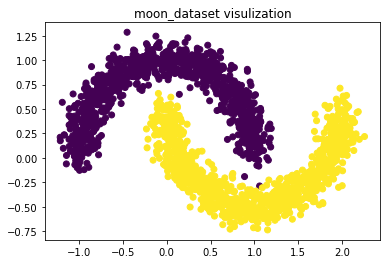

In [21]:
%matplotlib inline
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from node import Node, Graph
import numpy as np

# 生成 make_moons 数据集
X, y = make_moons(n_samples=2000, noise=0.1
                  , random_state=42)
# X是每个点的坐标(x, y)，y是每个点的label
nodes = []
index = 0
for df, label in zip(X, y):
    nodes.append(Node(df, label, index))
    index += 1
# scatter
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("moon_dataset visulization")
plt.show()

### 构建邻接矩阵

In [22]:
DISTANCE = 0.5
graph = Graph(nodes, distance=DISTANCE)
adjacency_matrix = np.array(graph.get_adjacency_matrix())
print("邻接矩阵：", adjacency_matrix.shape)

#根据邻接矩阵获取所有的二元组，如：[(0, 1), (0, 2), (1, 2)]
edges = graph.get_edges()
print(f"Distance={DISTANCE}, 构建了{len(edges)}条边")

邻接矩阵： (2000, 2000)
Distance=0.5, 构建了289371条边


### DeepWalk

#### Deepwalk策略定义

In [76]:
# deepwalk的游走策略
import networkx as nx
import gensim
import random

def deepwalk(graph, walk_length = 60, num_walks = 200, dim = 32):
    # 生成随机游走序列
    walks = []
    for _ in range(num_walks):
        node = random.choice(list(graph.nodes))
        walk = [node]
        while len(walk) < walk_length:
            neighbors = list(graph[node])
            next_node = neighbors[random.randint(0, len(neighbors) - 1)] if neighbors else node
            walk.append(next_node)
            node = next_node
        walks.append(walk)
    # print(walks, end = '\n')

    # 使用 gensim 的 Word2Vec 训练嵌入向量
    sentences = [list(map(str, walk)) for walk in walks]
    # for walk in walks:
    #     print(walk)
    # print(sentences)
    model = gensim.models.Word2Vec(sentences, vector_size=dim, window=walk_length, min_count=1, sg=1)
    node2vec = {str(node): model.wv[str(node)] if str(node) in model.wv else None for node in graph.nodes}
    # for node in graph.nodes:
        # print(node, model.wv[str(node)])
    return node2vec

#### Deepwalk嵌入，取两维简单做个可视化

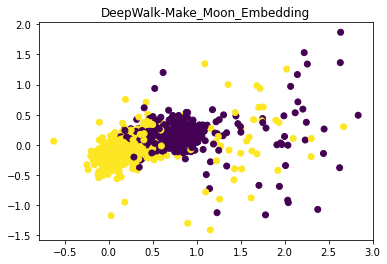

In [77]:
nx = graph.to_nx()
# print(nx.nodes)
embeddings = deepwalk(nx)
# embeddings

# 随便取两个维度看看
x = [embedding[0] for embedding in list(embeddings.values()) if embedding is not None]
y = [embedding[1] for embedding in list(embeddings.values()) if embedding is not None]



label = [node.label for node in nodes if(embeddings[str(node.index)] is not None)]

# 创建散点图
plt.scatter(x, y, c=label)
plt.title("DeepWalk-Make_Moon_Embedding")
# 显示图形
plt.show()

#### PCA降维，降到两维后做可视化

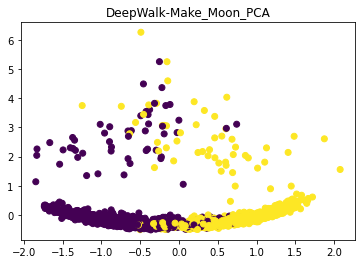

In [78]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 先drop掉None
embeddings = {key: value for key, value in embeddings.items() if value is not None}
# 假设embeddings是一个字典，其中包含嵌入值
embeddings_value = list(embeddings.values())

# 使用PCA进行降维
pca = PCA(n_components=2)
pca.fit(embeddings_value)
X_pca = pca.transform(embeddings_value)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label)
plt.title("DeepWalk-Make_Moon_PCA")
plt.show()


### Node2Vec

#### Node2Vec算法定义

In [79]:
import networkx as nx
import gensim
import random

def node2vec(graph, walk_length=60, num_walks=200, p=1.0, q=1.0, dim=32):
    # Generate random walk sequences
    walks = []
    for _ in range(num_walks):
        node = random.choice(list(graph.nodes))
        walk = [node]
        while len(walk) < walk_length:
            neighbors = list(graph.neighbors(node))
            if len(neighbors) > 0:
                if len(walk) == 1 or random.random() < p:
                    # Choose a neighbor at random with probability P
                    next_node = random.choice(neighbors)
                else:
                    # Choose a neighbor with probability proportional to the inverse of the square of the distance to the previous node
                    weights = [1.0 / q if n == walk[-1] else 1.0 for n in neighbors]
                    next_node = random.choices(neighbors, weights)[0]
                walk.append(next_node)
                node = next_node
            else:
                break
        walks.append(walk)

    # Use gensim's Word2Vec to train embedding vectors
    sentences = [list(map(str, walk)) for walk in walks]
    model = gensim.models.Word2Vec(sentences, vector_size=dim, window=walk_length, min_count=1, sg=1)
    node2vec = {str(node): model.wv[str(node)] if str(node) in model.wv else None for node in graph.nodes}
    return node2vec

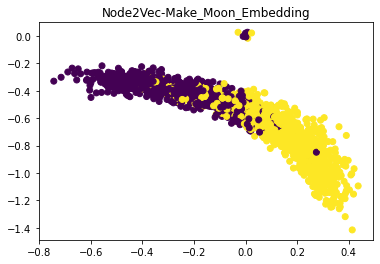

In [80]:
nx = graph.to_nx()
# print(nx.nodes)
embeddings = node2vec(nx)
# embeddings

# 随便取两个维度看看
x = [embedding[0] for embedding in list(embeddings.values()) if embedding is not None]
y = [embedding[1] for embedding in list(embeddings.values()) if embedding is not None]



label = [node.label for node in nodes if(embeddings[str(node.index)] is not None)]

# 创建散点图
plt.scatter(x, y, c=label)
plt.title("Node2Vec-Make_Moon_Embedding")
# 显示图形
plt.show()

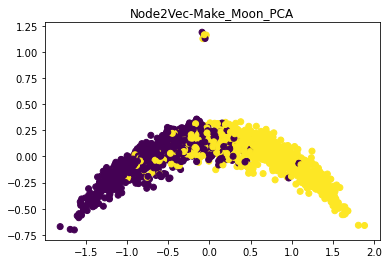

In [81]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 先drop掉None
embeddings = {key: value for key, value in embeddings.items() if value is not None}
# 假设embeddings是一个字典，其中包含嵌入值
embeddings_value = list(embeddings.values())

# 使用PCA进行降维
pca = PCA(n_components=2)
pca.fit(embeddings_value)
X_pca = pca.transform(embeddings_value)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label)
plt.title("Node2Vec-Make_Moon_PCA")
plt.show()


### GIN

Data(x=[2000, 2], edge_index=[2, 579986], y=[2000])
Epoch 1, Loss: 1.2966365814208984
Epoch 2, Loss: 1.229004979133606
Epoch 3, Loss: 1.004306674003601
Epoch 4, Loss: 0.8249076008796692
Epoch 5, Loss: 1.0237433910369873
Epoch 6, Loss: 1.0018901824951172
Epoch 7, Loss: 1.0456821918487549
Epoch 8, Loss: 1.1200121641159058
Epoch 9, Loss: 1.0971784591674805
Epoch 10, Loss: 0.9848945736885071
Epoch 11, Loss: 1.4492093324661255
Epoch 12, Loss: 0.8600900769233704
Epoch 13, Loss: 0.7459294199943542
Epoch 14, Loss: 0.5530409812927246
Epoch 15, Loss: 1.0250407457351685
Epoch 16, Loss: 0.5826439261436462
Epoch 17, Loss: 0.7803896069526672
Epoch 18, Loss: 0.8587146997451782
Epoch 19, Loss: 0.8177224397659302
Epoch 20, Loss: 0.7233511209487915
Epoch 21, Loss: 0.5470788478851318
Epoch 22, Loss: 0.4155479967594147
Epoch 23, Loss: 0.5138635635375977
Epoch 24, Loss: 0.4024750590324402
Epoch 25, Loss: 0.3758363127708435
Epoch 26, Loss: 0.32031241059303284
Epoch 27, Loss: 0.29783979058265686
Epoch 28, Lo

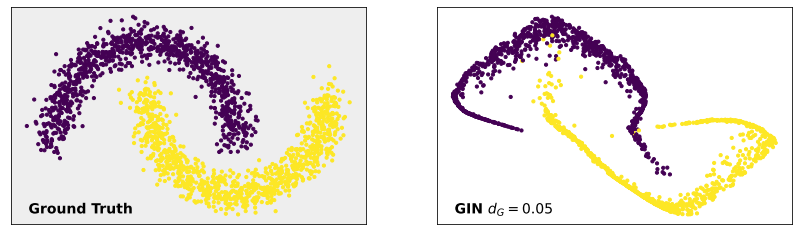

In [47]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx

from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data

from sklearn.manifold import TSNE
from sklearn.datasets import make_moons  # 导入make_moons函数

from util import Net, GIN, GAT, stationary, reconstruct, dG


np.random.seed(0)
torch.manual_seed(0)

n = 2000
m = 500

# 导入moon数据集
x, y = make_moons(n_samples=n, noise=0.1, random_state=0) 
# 分割训练集和测试机
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
# K = int(np.sqrt(n) * np.log2(n) / 10) #作为隐藏输入
D = pairwise_distances(x)# 邻接距离矩阵
# 二值化，得到邻接矩阵
A_binary = np.where(D <= DISTANCE, 1, 0)
# A_binary
# 获得所有的边，二元组格式
row_indices, col_indices = np.where(A_binary == 1)
edges = list(zip(row_indices, col_indices))

# 转为tensor
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
data = Data(x=x, y=y, edge_index=edges)
print(data)

# 喂到GIN网络中
net = GIN(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in range(100):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    # 将节点选择矩阵与特征矩阵连接在一起
    X_extended = torch.hstack([x, ind])
    data = Data(x=X_extended, edge_index=edges)
    rec = net(data) # reconstruct
    loss = dG(x[train_ind], rec[train_ind]) #train loss
    print(f'Epoch {epoch + 1}, Loss: {float(loss)}')
    optimizer.zero_grad() # zero gradient
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x.numpy(), rec.detach().numpy())
rec_GIN = rec.detach().numpy() @ R.T
loss_GIN = float(dG(x, rec))
# 创建图形
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# ax两个画布
ax[0].scatter(x[:, 0], x[:, 1], c=y, s=10, cmap='viridis', rasterized=True)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_facecolor('#eeeeee')
txt = ax[0].text(0.05, 0.05, 'Ground Truth', color='k', fontsize=14, weight='bold', transform=ax[0].transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='#eeeeee')])

# 绘制 GIN 网络的重构结果
ax[1].scatter(rec_GIN[:, 0], rec_GIN[:, 1], c=y, s=10, cmap='viridis', rasterized=True)
ax[1].set_xticks([])
ax[1].set_yticks([])
txt = ax[1].text(0.05, 0.05, f'GIN $d_G = {loss_GIN:.2f}$', color='k', fontsize=14, weight='bold', transform=ax[1].transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

fig.subplots_adjust()

if not os.path.exists('imgs'):
    os.mkdir('imgs')

fig.savefig('imgs/semi_moon_GIN.png', bbox_inches='tight', dpi=300)

plt.show()

### GAT

Data(x=[2000, 2], edge_index=[2, 579986], y=[2000])
Epoch 1, Loss: 1.3226933479309082
Epoch 2, Loss: 1.3210535049438477
Epoch 3, Loss: 1.3194568157196045
Epoch 4, Loss: 1.3177460432052612
Epoch 5, Loss: 1.315779447555542
Epoch 6, Loss: 1.3135368824005127
Epoch 7, Loss: 1.3108419179916382
Epoch 8, Loss: 1.307729959487915
Epoch 9, Loss: 1.304025411605835
Epoch 10, Loss: 1.2997366189956665
Epoch 11, Loss: 1.2944045066833496
Epoch 12, Loss: 1.2884502410888672
Epoch 13, Loss: 1.2816877365112305
Epoch 14, Loss: 1.2732723951339722
Epoch 15, Loss: 1.2638391256332397
Epoch 16, Loss: 1.2530652284622192
Epoch 17, Loss: 1.2405531406402588
Epoch 18, Loss: 1.225893497467041
Epoch 19, Loss: 1.2086588144302368
Epoch 20, Loss: 1.19096040725708
Epoch 21, Loss: 1.169481873512268
Epoch 22, Loss: 1.1469374895095825
Epoch 23, Loss: 1.1214882135391235
Epoch 24, Loss: 1.0929502248764038
Epoch 25, Loss: 1.0614311695098877
Epoch 26, Loss: 1.0270391702651978
Epoch 27, Loss: 0.9912488460540771
Epoch 28, Loss: 0.9

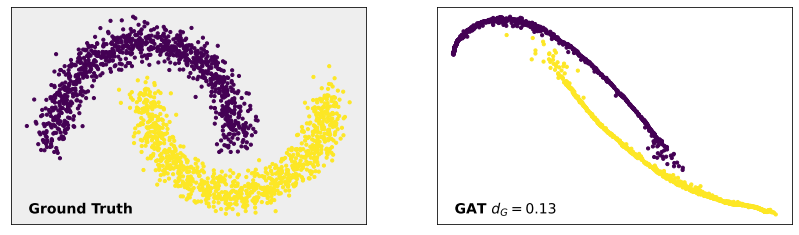

In [49]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx

from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data

from sklearn.manifold import TSNE
from sklearn.datasets import make_moons  # 导入make_moons函数

from util import Net, GIN, GAT, stationary, reconstruct, dG


np.random.seed(0)
torch.manual_seed(0)

n = 2000
m = 500

# 导入moon数据集
x, y = make_moons(n_samples=n, noise=0.1, random_state=0) 
# 分割训练集和测试机
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
# K = int(np.sqrt(n) * np.log2(n) / 10) #作为隐藏输入
D = pairwise_distances(x)# 邻接距离矩阵
# 二值化，得到邻接矩阵
A_binary = np.where(D <= DISTANCE, 1, 0)
# A_binary
# 获得所有的边，二元组格式
row_indices, col_indices = np.where(A_binary == 1)
edges = list(zip(row_indices, col_indices))

# 转为tensor
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
data = Data(x=x, y=y, edge_index=edges)
print(data)

# 喂到GAT网络中
net = GAT(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in range(100):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    # 将节点选择矩阵与特征矩阵连接在一起
    X_extended = torch.hstack([x, ind])
    data = Data(x=X_extended, edge_index=edges)
    rec = net(data) # reconstruct
    loss = dG(x[train_ind], rec[train_ind]) #train loss
    print(f'Epoch {epoch + 1}, Loss: {float(loss)}')
    optimizer.zero_grad() # zero gradient
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x.numpy(), rec.detach().numpy())
rec_GIN = rec.detach().numpy() @ R.T
loss_GIN = float(dG(x, rec))
# 创建图形
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# ax两个画布
ax[0].scatter(x[:, 0], x[:, 1], c=y, s=10, cmap='viridis', rasterized=True)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_facecolor('#eeeeee')
txt = ax[0].text(0.05, 0.05, 'Ground Truth', color='k', fontsize=14, weight='bold', transform=ax[0].transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='#eeeeee')])

# 绘制 GIN 网络的重构结果
ax[1].scatter(rec_GIN[:, 0], rec_GIN[:, 1], c=y, s=10, cmap='viridis', rasterized=True)
ax[1].set_xticks([])
ax[1].set_yticks([])
txt = ax[1].text(0.05, 0.05, f'GAT $d_G = {loss_GIN:.2f}$', color='k', fontsize=14, weight='bold', transform=ax[1].transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

fig.subplots_adjust()

if not os.path.exists('imgs'):
    os.mkdir('imgs')

fig.savefig('imgs/semi_moon_GAT.png', bbox_inches='tight', dpi=300)

plt.show()